In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
from flash.image import ImageClassificationData, ImageClassifier
from flash import Trainer

In [5]:
LOGDIR = 'training-metrics'
NORMALIZED_DATA = '../../Training-baseline/'
EPOCHS = 20
FINETUNE_STRATEGY = 'freeze'
VERSION = (str(EPOCHS) + 'Epochs-' + FINETUNE_STRATEGY)

In [6]:
metrics = pd.read_csv(f'{LOGDIR}/{VERSION}.csv')
display(metrics)

,Unnamed: 0,train_loss,train_acc,val_loss,val_acc,trainf1,valf1
0,0,2.324524,0.597969,1.959274,0.608609,0.157386,0.267922
1,1,1.862351,0.700188,1.748879,0.646358,0.313153,0.370077
2,2,1.637691,0.722817,1.655688,0.653974,0.407893,0.412474
3,3,1.496362,0.711778,1.605677,0.656954,0.464993,0.433357
4,4,1.374349,0.730544,1.563392,0.684768,0.505067,0.447022
5,5,1.265592,0.720057,1.544270,0.678477,0.542096,0.457335
6,6,1.176982,0.721934,1.525777,0.687417,0.570508,0.464752
7,7,1.112559,0.728888,1.530666,0.659934,0.599042,0.456358
8,8,1.036940,0.724914,1.522409,0.749338,0.628609,0.467093
9,9,0.971796,0.722044,1.526019,0.725166,0.652473,0.462174


<AxesSubplot:title={'center':'Loss'}>

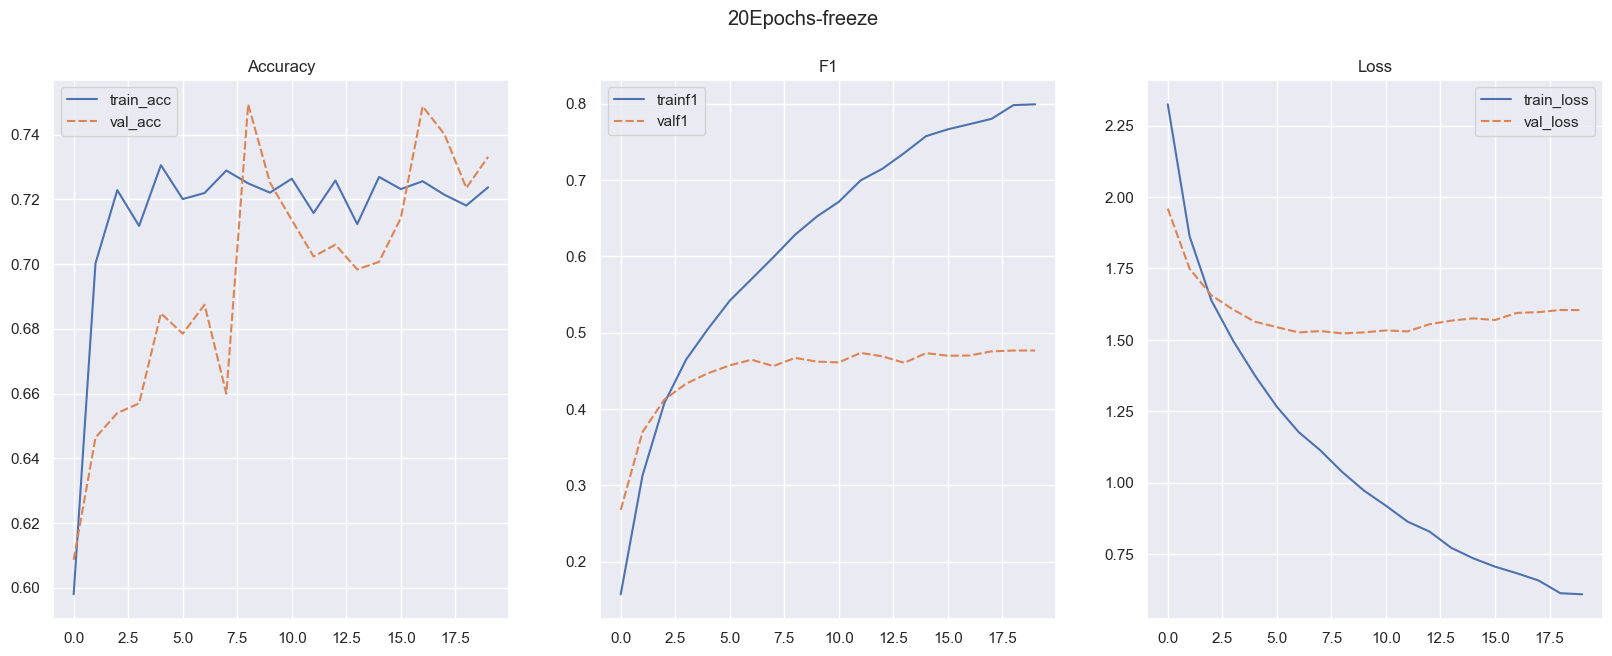

In [7]:
sns.set()

figure, axes = plt.subplots(1, 3, sharex='all', figsize=(20,7))
figure.suptitle(VERSION)
axes[0].set_title('Accuracy')
axes[1].set_title('F1')
axes[2].set_title('Loss')

sns.lineplot(data=metrics[['train_acc', 'val_acc']], ax=axes[0])
sns.lineplot(data=metrics[['trainf1', 'valf1']], ax=axes[1])
sns.lineplot(data=metrics[['train_loss', 'val_loss']], ax=axes[2])